In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.notebook import tqdm, trange

In [2]:
torch.set_float32_matmul_precision("high")

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            self.conv_block(3, 64),     # B x 64 x 64 x 64
            self.conv_block(64, 128),   # B x 128 x 32 x 32
            self.conv_block(128, 128),  # B x 128 x 16 x 16
            self.conv_block(128, 128),  # B x 128 x 8 x 8
            self.conv_block(128, 128),  # B x 128 x 4 x 4
            self.conv_block(128, 128),  # B x 128 x 2 x 2
        )
        self.flatten = nn.Flatten()
        self.z_mu = nn.Linear(128 * 2 * 2, 200)
        self.z_logvar = nn.Linear(128 * 2 * 2, 200)

    @staticmethod
    def conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(1e-2)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        return self.z_mu(x), self.z_logvar(x)

In [4]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(200, 128 * 2 * 2) # match the input
        self.deconv_layers = nn.Sequential(
            self.deconv_block(128, 128),    # B x 128 x 2 x 2
            self.deconv_block(128, 128),    # B x 128 x 4 x 4
            self.deconv_block(128, 128),    # B x 128 x 8 x 8
            self.deconv_block(128, 128),    # B x 128 x 16 x 16
            self.deconv_block(128, 64),     # B x 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # B x 3 x 64 x 64
            nn.Sigmoid()
        )

    @staticmethod
    def deconv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(1e-2)
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 128, 2, 2)
        return self.deconv_layers(x)

In [5]:
class Sampling(nn.Module):
    def forward(self, z_mean, z_logvar):
        epsilon = torch.randn_like(z_mean)
        return z_mean + torch.exp(0.5 * z_logvar) * epsilon

In [6]:
def KL_Divergence_Loss(z_mean,z_logvar):
    loss = -0.5 * torch.sum(1 + z_logvar - z_mean.pow(2) - z_logvar.exp())
    loss = loss.mean()
    return loss

criterion = nn.MSELoss(reduction='mean')

In [7]:
device = (
    torch.device("mps") if torch.backends.mps.is_available() else
    torch.device("cuda") if torch.cuda.is_available() else
    torch.device("cpu")
)
print(f"Using device: {device}")

Using MPS (Apple Metal Performance Shaders) backend


In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.sampling_layer = Sampling()

    def forward(self, x):
        z_mean, z_logvar = self.encoder(x)
        kl_loss = KL_Divergence_Loss(z_mean, z_logvar)
        z_sample = self.sampling_layer(z_mean, z_logvar)
        return kl_loss, self.decoder(z_sample)

In [9]:
model = AutoEncoder().to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, threshold=0.001)
beta = 1.0

In [10]:
beta = 1.0

val_losses = []

In [11]:
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [12]:
class ImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_path = self.data_frame.iloc[idx]['filepath']
        age = self.data_frame.iloc[idx]['age']
        gender = self.data_frame.iloc[idx]['gender']

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label = torch.tensor([age, gender], dtype=torch.float32)

        return image, label

In [13]:
batch_size = 64

train_csv = "Dataset/Index/Train.csv"
val_csv = "Dataset/Index/Validation.csv"
test_csv = "Dataset/Index/Test.csv"

train_dataset = ImageDataset(train_csv, transform=image_transforms)
val_dataset = ImageDataset(val_csv, transform=image_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

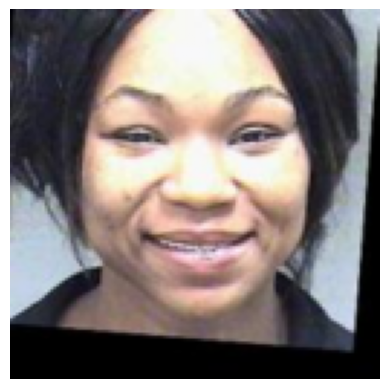

In [14]:
import matplotlib.pyplot as plt

sample_batch = next(iter(train_loader))

sample_image, _ = sample_batch

sample_image = sample_image[0].cpu().numpy().transpose(1, 2, 0)

sample_image = (sample_image * 0.5) + 0.5

plt.imshow(sample_image)
plt.axis("off")
plt.show()

In [15]:
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, epoch, loss, filename):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filename)

In [34]:
checkpoint_path = "./checkpoints/checkpoint_epoch_20.pth"

checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch'] + 1
last_loss = checkpoint['loss']

print(f"Resuming training from Epoch {start_epoch} with last loss {last_loss:.4f}")

Resuming training from Epoch 20 with last loss 0.0051


In [20]:
epochs = 20

In [21]:
for epoch in trange(start_epoch, epochs, desc="Epoch Progress", position=0, leave=True):
    model.train()
    total_loss = 0
    total_kl_loss = 0
    total_rec_loss = 0
    num_batches = len(train_loader)

    with tqdm(train_loader, desc=f"Training Epoch {epoch+1}", position=1, leave=False, dynamic_ncols=True) as pbar:
        for xb, yb in pbar:
            optimizer.zero_grad(set_to_none=True)

            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            kl_loss, outs = model(xb)

            reconstructed_loss = criterion(xb, outs)
            reconstructed_loss = reconstructed_loss/batch_size

            total_kl_loss += kl_loss.item()
            total_rec_loss += reconstructed_loss.item()

            loss = reconstructed_loss + beta * kl_loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    avg_train_loss = total_loss / num_batches
    avg_rec_loss = total_rec_loss / num_batches
    avg_kl_loss = total_kl_loss / num_batches

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        with tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", position=2, leave=False, dynamic_ncols=True) as pbar:
            for xb, yb in pbar:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                model = model.to(device)

                kl_loss, outs = model(xb)

                reconstructed_loss = criterion(xb, outs) / batch_size
                val_loss = reconstructed_loss + beta * kl_loss
                total_val_loss += val_loss.item()

                pbar.set_postfix({"Val Loss": val_loss.item()})

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch + 1}/{epochs} - "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_val_loss:.4f}, "
          f"Rec Loss: {avg_rec_loss:.4f}, "
          f"KL Loss: {avg_kl_loss:.4f}")

    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    checkpoint_filename = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pth')
    save_checkpoint(model, optimizer, epoch, avg_train_loss, checkpoint_filename)

    scheduler.step(avg_val_loss)

Epoch Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 11:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/20 - Train Loss: 0.0642, Validation Loss: 0.0357, Rec Loss: 0.0039, KL Loss: 0.0603
Learning Rate: 0.010000


Training Epoch 12:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/20 - Train Loss: 0.0373, Validation Loss: 0.0240, Rec Loss: 0.0039, KL Loss: 0.0334
Learning Rate: 0.010000


Training Epoch 13:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 13:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/20 - Train Loss: 0.0243, Validation Loss: 0.0152, Rec Loss: 0.0039, KL Loss: 0.0204
Learning Rate: 0.010000


Training Epoch 14:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 14:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/20 - Train Loss: 0.0156, Validation Loss: 0.0229, Rec Loss: 0.0039, KL Loss: 0.0117
Learning Rate: 0.010000


Training Epoch 15:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 15:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/20 - Train Loss: 0.0122, Validation Loss: 0.0094, Rec Loss: 0.0039, KL Loss: 0.0083
Learning Rate: 0.010000


Training Epoch 16:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 16:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/20 - Train Loss: 0.0100, Validation Loss: 0.0134, Rec Loss: 0.0039, KL Loss: 0.0061
Learning Rate: 0.010000


Training Epoch 17:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 17:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/20 - Train Loss: 0.0090, Validation Loss: 0.0147, Rec Loss: 0.0039, KL Loss: 0.0051
Learning Rate: 0.010000


Training Epoch 18:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 18:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/20 - Train Loss: 0.0089, Validation Loss: 0.0157, Rec Loss: 0.0039, KL Loss: 0.0050
Learning Rate: 0.010000


Training Epoch 19:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 19:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/20 - Train Loss: 0.0093, Validation Loss: 0.0187, Rec Loss: 0.0039, KL Loss: 0.0054
Learning Rate: 0.010000


Training Epoch 20:   0%|          | 0/626 [00:00<?, ?it/s]

Validation Epoch 20:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/20 - Train Loss: 0.0051, Validation Loss: 0.0051, Rec Loss: 0.0039, KL Loss: 0.0012
Learning Rate: 0.001000


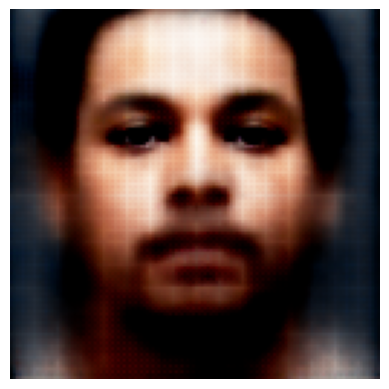

In [37]:
model.eval()
zsample = torch.randn(1, 200).to(device)

with torch.no_grad():
    gen_img = model.decoder(zsample).cpu().squeeze(0).numpy().transpose(1, 2, 0)
    plt.imshow(gen_img)
    plt.axis("off")
    plt.show()